In this tutorial we'll:

1. Briefly talk about neural networks, deep learning, and multiclass classification
2. Use Keras build models to learn the "MNIST" dataset
3. We'll first use Logistic Regression to learn a binary dataset
3. We'll first use Logistic Regression to learn the full multiclass dataset
4. We'll then use a simple neural network very similar to LR called a "Multilayer Logistic Regression"
5. We'll investigating how changing the number of layers effects the accuracy
6. We'll look at a fancier way to combine the layers, and how that can improve performance
6. We'll briefly see a fancier network that gets nearly state of the art (99%!) accuracy


# Part 1: Background 

## What are neural networks & deep learning?

We'll talk about them in class soon! One good source of explanation is: http://neuralnetworksanddeeplearning.com/chap1.html

We've already seen Logistic Regression in class. It's like SVM, but with a different loss.

<img src="perceptron.png" width="300">

When we used Logistic Regression in class, we classified based on whether the dot product of the example and the weights was *less than 0*. In neural networks this function- which decides whether or not an example is positive based on this dot product- is called an *activation function*. Many neural networks can learn non-linear functions because they use other activation functions such as "relu".

A neural network is made by chaining a few "neurons" togther:

<img src="nn.png" width="300">

What you need to know:

* A neural network is a non-linear classifier, like a decision tree

* In practice, they seem to work very well for certain kinds of data including images and text

* Neural networks are organized into "layers". Lots of choices of how exactly you set up these layer; a "deep neural network" is a neural network with many layers.

* A perceptron-like classifier is a very simple neural network (a single-layer neural network neural network)


## What is Keras & what is it used for?

Keras is a library for deep learning, designed to make common types of neural networks very easy to work with.

* It's a layer on top of a more powerful, but more difficult to use, library called TensorFlow.

* If you want to use "standard" neural nets, Keras is better; if you want to use very fancy or complicated models you should use Tensorflow.
    
* Tons of examples:
https://github.com/fchollet/keras/tree/master/examples

You can create a model in Keras by specifying which model you want to use, and how you want to train it; Keras takes care of the rest. Keras has many options of "standard" models.
   
   
## MNIST

Handwritten digit dataset taken from high school students:

<img src="mnist.png" width="300">

There are 70,000 examples to test and train on, with 10 labels (the digits 0 through 9)

The state-of-the art accuracy for this dataset is 99.79% accuracy!

### Multi-class classification 

We'll use "one v. all" multiclass because there are 10 labels, we're actually going to need a multi-class classifier.


#### Training a 10 way classifier: train 10 binary classifiers
What this actually means is we're going to train 10 binary classifier!

ie: 

a "0 or not 0" classifier

a "1 or not 1" classifier

a "2 or not 2" classifier

etc

#### Testing with a 10 way classifier: let all the classifiers "vote"

Then, at test time, each classifier "votes" and we choose the label based on the "most confident" vote.

ie, at test time we have an example that is truely a "1"

the "0 or not 0" classifier returns a negative value (meaning "it's not a 0!")

the "1 or not 1" classifier returns **a positive value** (meaning "it's a 1!")

the "2 or not 2" classifier returns a negative value (meaning "it's not a 2!")

etc

so we label the example as a "1".

-----

#  Setting up the Data

Adapted from https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py


Note: use Shift+Enter to run the codeblocks

In [ ]:
import keras
import numpy as np
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import SGD, Adam
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib figure size and make inline
matplotlib.rcParams['figure.figsize'] = [10, 6]
%matplotlib inline

### Split our data into a training & testing set

`x_train` & `x_test` are the examples, and `y_train` & `y_test` are the labels.

In [2]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test  = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

# normalize the pixel values to be in the range (0, 1)
x_train /= 255 
x_test  /= 255


print("Number of training samples in full dataset: " + str(x_train.shape[0]))
print("Number of testing samples in full dataset: " + str(x_test.shape[0]))

# Create a binary version for binary classification
df = pd.DataFrame(np.vstack([x_train, x_test]))
df['label'] = pd.Series(np.concatenate([y_train, y_test]))
binary_data = df[df['label'].isin([0, 1])]


binary_x_train = binary_data.iloc[:10000].drop(['label'], axis=1).as_matrix()
binary_x_test  = binary_data.iloc[10000:].drop(['label'], axis=1).as_matrix()
binary_y_train = binary_data.iloc[:10000]['label'].as_matrix()
binary_y_test  = binary_data.iloc[10000:]['label'].as_matrix()

print()
print("Total number of binary 0 / 1 examples: ", binary_data.shape)
print("Number of training samples in BINARY dataset: " + str(binary_x_train.shape[0]))
print("Number of testing samples in BINARY dataset: " + str(binary_x_test.shape[0]))

Number of training samples in full dataset: 60000
Number of testing samples in full dataset: 10000

Total number of binary 0 / 1 examples:  (14780, 785)
Number of training samples in BINARY dataset: 10000
Number of testing samples in BINARY dataset: 4780


### Check out what our data looks like

Let's plot one of the training examples

The shape of each image is(784,)


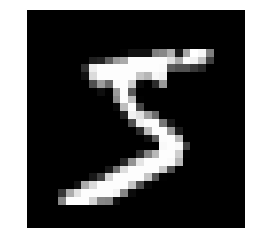

In [3]:
image = x_train[0]
img_rows, img_cols, channels = 28, 28, 1
image = np.reshape(image, [img_rows, img_cols])
plt.imshow(image, cmap='gray')
plt.axis('off')

# The shape of each image is a vector with 784 binary values ("pixels")
image_shape = x_train[0].shape
print("The shape of each image is" + str(image_shape))

# Binary classification

### Let's make our model!!

We're going to train a model that Keras calls a "Sequential" model.

Sequential is an abstraction for really simple networks. There are many ways you can "link" the neurons between layers in a neural network, and "Sequential" is the simplest way to link these layers. Since we're training a single layer network, this doesn't really concern us.

Sidenote: The alternative to in Keras to Sequential models are "Functional" models. You can use those to make fancier networks.

In [4]:
binary_model = Sequential()
num_classes = 1
binary_model.add(Dense(num_classes, activation='sigmoid', input_shape=image_shape))


### Compiling the model

Now that we've told the Keras *what the model is*, we now need to tell it *how to learn*.

1. What's the loss function?

    In class we've seen some loss functions like the hinge loss and the SVM loss. Here we're going to use a different loss function called the "binary crossentropy" loss. Cross-entropy is a loss function that works well for learning because it makes learning very fast when your function is "very wrong" but slower when it is pretty close to the true function.


2. What's the optimizer?

    We'll use SGD (Stochastic Gradient Descent) which we've already discussed in class.
    

3. Which metric to optimize?

    We'll use accuracy- which is what we've been using for our algorithms all semester. There are some other options that make sense for other types of datasets. 

In [5]:
binary_model.compile(loss='binary_crossentropy', optimizer=SGD(), metrics=['accuracy'])

In [6]:
global_batch_size = 128
num_epochs = 10

history = binary_model.fit(binary_x_train, binary_y_train,
                   batch_size=global_batch_size, # average 128 examples in each SGD test
                   epochs=num_epochs,
                   verbose=1,
                   validation_data=(binary_x_test, binary_y_test)) #TODO

Train on 10000 samples, validate on 4780 samples
Epoch 1/10
10000/10000 [==============================] - 0s 41us/step - loss: 0.2880 - acc: 0.9690 - val_loss: 0.1379 - val_acc: 0.9960
Epoch 2/10
10000/10000 [==============================] - 0s 12us/step - loss: 0.1092 - acc: 0.9953 - val_loss: 0.0797 - val_acc: 0.9969
Epoch 3/10
10000/10000 [==============================] - 0s 13us/step - loss: 0.0729 - acc: 0.9960 - val_loss: 0.0576 - val_acc: 0.9973
Epoch 4/10
10000/10000 [==============================] - 0s 17us/step - loss: 0.0564 - acc: 0.9966 - val_loss: 0.0459 - val_acc: 0.9977
Epoch 5/10
10000/10000 [==============================] - 0s 16us/step - loss: 0.0469 - acc: 0.9967 - val_loss: 0.0386 - val_acc: 0.9977
Epoch 6/10
10000/10000 [==============================] - 0s 17us/step - loss: 0.0406 - acc: 0.9968 - val_loss: 0.0336 - val_acc: 0.9979
Epoch 7/10
10000/10000 [==============================] - 0s 16us/step - loss: 0.0361 - acc: 0.9970 - val_loss: 0.0298 - val_acc:

### Check out that accuracies!

99% accuracy!

Let's try it on our *test set* instead of our *validation set* now

In [7]:
score = binary_model.evaluate(binary_x_test, binary_y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0228652525319
Test accuracy: 0.998117154812


# Multi-class classification!

###  Format the labels

The labels are currently formatted as numeric values, ie the image above has the label `5`.

Since we're training 10 binary classifiers, we need to convert the labels into binary values.

ie, the label `1` becomes the array `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]`. The entry in the "1th" position is true, and all others are false. 


In [8]:
# classifying 10 digits
num_classes = 10


print("shape of our labels before" + str(y_train.shape))
print("the first 3 labels look like:") 
print(str(y_train[0:5]) + '\n')


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

print("shape of our labels after" + str(y_train.shape))
print("the first 3 labels look like:") 
print(str(y_train[0:5]))

shape of our labels before(60000,)
the first 3 labels look like:
[5 0 4 1 9]

shape of our labels after(60000, 10)
the first 3 labels look like:
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


Now that our data is good to go, let's train our 10 classifiers!


### Let's make our model!!

In [9]:
logistic_reg_model = Sequential()
logistic_reg_model.add(Dense(num_classes, activation='softmax', input_shape=image_shape))

### Compile the model

In [10]:
logistic_reg_model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

### Fit the model & store accuracies!

Note: turning on verbosity can slow things down *a lot* so if you're running some large model, turn it off.

In [11]:
global_batch_size = 128
num_epochs = 10

history = logistic_reg_model.fit(x_train, y_train,
                   batch_size=global_batch_size, # average 128 examples in each SGD test
                   epochs=num_epochs,
                   verbose=1,
                   validation_data=(x_test, y_test))


score = logistic_reg_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 22us/step - loss: 1.2563 - acc: 0.7067 - val_loss: 0.8079 - val_acc: 0.8321
Epoch 2/10
60000/60000 [==============================] - 1s 20us/step - loss: 0.7133 - acc: 0.8390 - val_loss: 0.6065 - val_acc: 0.8623
Epoch 3/10
60000/60000 [==============================] - 1s 24us/step - loss: 0.5863 - acc: 0.8592 - val_loss: 0.5254 - val_acc: 0.8743
Epoch 4/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.5250 - acc: 0.8698 - val_loss: 0.4800 - val_acc: 0.8813
Epoch 5/10
60000/60000 [==============================] - 1s 17us/step - loss: 0.4876 - acc: 0.8760 - val_loss: 0.4500 - val_acc: 0.8863
Epoch 6/10
60000/60000 [==============================] - 1s 16us/step - loss: 0.4617 - acc: 0.8809 - val_loss: 0.4287 - val_acc: 0.8897
Epoch 7/10
60000/60000 [==============================] - 1s 18us/step - loss: 0.4426 - acc: 0.8843 - val_loss: 0.4126 - val_acc

-----

# Part 4: learning MNIST with a Multilayer Network!

We'll set up a new model

TODO ADD DIAGRAM OF WHAT THIS IS

In [12]:
mlp_model = Sequential()
mlp_model.add(Dense(512, activation='relu', input_shape=image_shape))
mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(Dense(num_classes, activation='softmax'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


### Compile the MLP

We'll compile with the same parameters as before so that it's a fair comparison.

In [13]:
mlp_model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

### Fit & Evaluate

In [14]:
global_batch_size = 128
num_epochs = 10

history = mlp_model.fit(x_train, y_train,
                   batch_size=global_batch_size, # average 128 examples in each SGD test
                   epochs=num_epochs,
                   verbose=1,
                   validation_data=(x_test, y_test))

score = mlp_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 117us/step - loss: 1.1063 - acc: 0.7520 - val_loss: 0.5226 - val_acc: 0.8743
Epoch 2/10
60000/60000 [==============================] - 7s 116us/step - loss: 0.4504 - acc: 0.8826 - val_loss: 0.3668 - val_acc: 0.9031
Epoch 3/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.3581 - acc: 0.9013 - val_loss: 0.3134 - val_acc: 0.9140
Epoch 4/10
60000/60000 [==============================] - 6s 103us/step - loss: 0.3168 - acc: 0.9109 - val_loss: 0.2857 - val_acc: 0.9208
Epoch 5/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.2904 - acc: 0.9177 - val_loss: 0.2656 - val_acc: 0.9268
Epoch 6/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.2708 - acc: 0.9241 - val_loss: 0.2493 - val_acc: 0.9310
Epoch 7/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.2546 - acc: 0.9282 - val_loss: 0.2371 - 

-----
# Part 5: How deep can you go: can adding more layers help us?

Creating a deep model gives us some performance gains, but it's not a panacea.  Let's see how model performance behaves as we add more layers.

In [ ]:
def depth_accuracy_analysis(x_train, y_train, x_test, y_test, max_layers, layer_size =128, verbose=False):
    # type: (np.ndarray, np.ndarray, np.ndarray, np.ndarray, int, int, bool) -> List[float]
    """This method creates deep feedforward networks of varyig depth from 1 layer to max_layers.  It
    returns a list of accuracies on the test set
    
    Args:
        x_train: An np.ndarray of data where each row is a new data point
        y_train: An np.ndarray of labels where each row is a binary vector with
            1 in the column of the associated class
        x_test: An np.ndarray of data where each row is a new data point
        y_test: An np.ndarray of labels where each row is a binary vector with
            1 in the column of the associated class
        max_layers: An int the maximum depth to try
        layer_size: The number of neurons in each layer
    
    Returns:
        A List of floats as the accuracies of the model on the test set
    """
    acc_scores = []
    
    # Build up and test 1 - max layers
    for i in range(0, max_layers):
        mlp_model = Sequential()
        mlp_model.add(Dense(layer_size, activation='relu', input_shape=x_train[0].shape))
        
        # Add i layers
        for j in range(1, i):
            mlp_model.add(Dense(layer_size, activation='relu'))

        mlp_model.add(Dense(y_train.shape[1], activation='softmax'))
        mlp_model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])
        history = mlp_model.fit(x_train, y_train,
                        batch_size=128,
                        epochs=10,
                        verbose=0,
                        validation_data=(x_test, y_test))
        score = mlp_model.evaluate(x_test, y_test, verbose=0)
        
        # Print out scores if verbosity is non 0
        if verbose:
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])
        acc_scores.append(score)
    
    return acc_scores

In [16]:
max_layers = 30
layer_size = 128
scores = depth_accuracy_analysis(x_train, y_train, x_test, y_test, max_layers, layer_size=layer_size)

KeyboardInterrupt: 

In [ ]:
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, max_layers + 1), map(lambda x: x[1], scores), 'o-')
plt.title('Behaviour of model accuracy with depth')
plt.ylabel('Testing Accuracy')
plt.xlabel('Number of layers with {} nodes/layer'.format(layer_size))

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, max_layers + 1), map(lambda x: x[0], scores), 'o-')
plt.title('Behaviour of model loss with depth')
plt.ylabel('Testing loss')
plt.xlabel('Number of layers with {} nodes/layer'.format(layer_size))
plt.tight_layout()
plt.savefig('depth_experiment_{}-layers_{}-layer_size.png'.format(max_layers, layer_size))
plt.show()

Here are the results:

<img src="depth_experiment_30-layers_128-layer_size.png" width="800">

-----

# Part 6: If adding more layers isn't helping, can we get smarter about the network?

There are many different types of layers that we can use when building a network.  Right now we have just seen dense layers which are simply perceptron-like nodes stacked together.  Here we will use a set of layers that are well adapted to images called convoluational, and pooling layers.  If you are interested in understanding how these work check out this great paper https://arxiv.org/pdf/1603.07285.pdf.  For now, you can think of the convlutional layers as learning filter like features of increasing complexity.  We will need to redefine our data in order to work with these layers.  Convolutions work on a matrix of values as opposed to a flattened array, because the filters take into consideration local patterns.

In [17]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
image_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [18]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=image_shape))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(num_classes, activation='softmax'))

#cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dense_18 (Dense)             (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
_________________________________________________________________


In [19]:
cnn_model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

In [20]:
history = cnn_model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 8960/60000 [===>..........................] - ETA: 2:38 - loss: 2.0424 - acc: 0.4744

KeyboardInterrupt: 

----
# Part 7: State of the Art-ish Accuracy

The state of the art on MNIST is 99.79% accuracy.  With a little extra work we can push our conv net pretty close to this at ~99.16% accuracy.  We can do this by adding regularization in the form of drop out and a better optimizer in the form of ADAM.

In [ ]:
# Best CNN
best_cnn_model = Sequential()
best_cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                   activation='relu',
                   input_shape=image_shape))
best_cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
best_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
best_cnn_model.add(Dropout(.5))
best_cnn_model.add(Flatten())
best_cnn_model.add(Dense(128, activation='relu'))
best_cnn_model.add(Dropout(.5))
best_cnn_model.add(Dense(num_classes, activation='softmax'))

best_cnn_model.summary()

In [ ]:
best_cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
history = best_cnn_model.fit(x_train, y_train,
                             batch_size=128,
                             epochs=10,
                             verbose=1,
                             validation_data=(x_test, y_test))

In [ ]:
score = best_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

----
# Part 8: Cool stuff with neural nets

Michael Nielsen's book is awesome: http://neuralnetworksanddeeplearning.com/

Lots of keras tutorials: https://github.com/fchollet/keras/tree/master/examples

"Deep art": https://deepart.io/

Twitter bot neural net text generation: https://twitter.com/DeepProverbs

Adversarial 

Generated cat images from outlines: https://affinelayer.com/pixsrv/
